# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0800s1"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(4927, 32, 32, 3)
(4927, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
616/616 [==============================] - 14s 22ms/step - loss: 0.1477 - accuracy: 0.8571 - val_loss: 0.0140 - val_accuracy: 0.9716
Epoch 2/30
616/616 [==============================] - 13s 22ms/step - loss: 0.0162 - accuracy: 0.9694 - val_loss: 0.0105 - val_accuracy: 0.9696
Epoch 3/30
616/616 [==============================] - 13s 22ms/step - loss: 0.0097 - accuracy: 0.9748 - val_loss: 0.0065 - val_accuracy: 0.9807
Epoch 4/30
616/616 [==============================] - 11s 17ms/step - loss: 0.0060 - accuracy: 0.9787 - val_loss: 0.0059 - val_accuracy: 0.9919
Epoch 5/30
616/616 [==============================] - 9s 15ms/step - loss: 0.0044 - accuracy: 0.9848 - val_loss: 0.0052 - val_accuracy: 0.9858
Epoch 6/30
616/616 [==============================] - 9s 15ms/step - loss: 0.0033 - accuracy: 0.9838 - val_loss: 0.0026 - val_accuracy: 0.9878
Epoch 7/30
616/616 [==============================] - 9s 15ms/

### Step 1: Learing result
 
* Visualization of the training and validation results

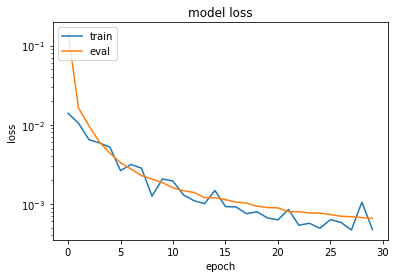

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
616/616 [==============================] - 10s 17ms/step - loss: 0.0371 - accuracy: 0.9470 - val_loss: 0.0120 - val_accuracy: 0.9665
Epoch 2/160
616/616 [==============================] - 10s 17ms/step - loss: 0.0079 - accuracy: 0.9779 - val_loss: 0.0046 - val_accuracy: 0.9838
Epoch 3/160
616/616 [==============================] - 11s 18ms/step - loss: 0.0052 - accuracy: 0.9830 - val_loss: 0.0041 - val_accuracy: 0.9716
Epoch 4/160
616/616 [==============================] - 11s 17ms/step - loss: 0.0037 - accuracy: 0.9856 - val_loss: 0.0024 - val_accuracy: 0.9909
Epoch 5/160
616/616 [==============================] - 11s 17ms/step - loss: 0.0031 - accuracy: 0.9854 - val_loss: 0.0032 - val_accuracy: 0.9878
Epoch 6/160
616/616 [==============================] - 11s 17ms/step - loss: 0.0029 - accuracy: 0.9848 - val_loss: 0.0022 - val_accuracy: 0.9787
Epoch 7/160
616/616 [==============================] - 11s 17ms/step - loss: 0.0024 - accuracy: 0.9868 - val_loss: 0.0024 - val_ac

616/616 [==============================] - 18s 30ms/step - loss: 7.5158e-04 - accuracy: 0.9939 - val_loss: 0.0011 - val_accuracy: 0.9919
Epoch 56/160
616/616 [==============================] - 19s 30ms/step - loss: 7.3127e-04 - accuracy: 0.9953 - val_loss: 6.2781e-04 - val_accuracy: 0.9959
Epoch 57/160
616/616 [==============================] - 18s 30ms/step - loss: 7.2706e-04 - accuracy: 0.9947 - val_loss: 7.3146e-04 - val_accuracy: 0.9939
Epoch 58/160
616/616 [==============================] - 18s 29ms/step - loss: 6.3387e-04 - accuracy: 0.9961 - val_loss: 5.7077e-04 - val_accuracy: 0.9949
Epoch 72/160
616/616 [==============================] - 19s 31ms/step - loss: 6.4279e-04 - accuracy: 0.9941 - val_loss: 6.1730e-04 - val_accuracy: 0.9929
Epoch 73/160
616/616 [==============================] - 18s 30ms/step - loss: 6.1590e-04 - accuracy: 0.9943 - val_loss: 7.5764e-04 - val_accuracy: 0.9899
Epoch 74/160
616/616 [==============================] - 19s 30ms/step - loss: 6.1473e-04 - ac

### Overall Learing results (Step 1 & Step 2)

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\6.7_3341_zeiger1_2020-04-29_14-29-02.jpg 0.67 0.7425277471183745 -0.07252774711837451
data_resize_all\7.7_3896_zeiger1_2020-04-29_13-17-02.jpg 0.77 0.860193910866506 -0.09019391086650597
data_resize_all\7.7_3914_zeiger3_2020-04-29_12-09-01.jpg 0.77 0.7192716549861458 0.05072834501385426
data_resize_all\7.7_3924_zeiger1_2020-04-29_14-37-02.jpg 0.77 0.8446841544585872 -0.07468415445858723
data_resize_all\7.7_3967_zeiger1_2020-04-29_14-38-02.jpg 0.77 0.8322308033541369 -0.06223080335413689
data_resize_all\7.9_3968_zeiger1_2020-04-29_14-39-02.jpg 0.79 0.8448969338239809 -0.054896933823980865


## Results

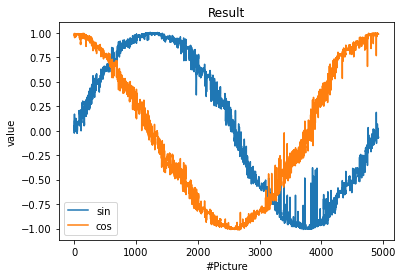

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

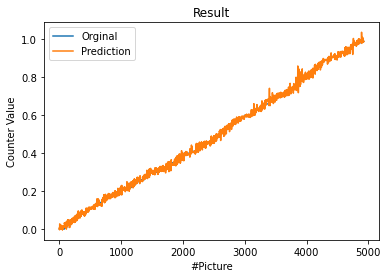

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

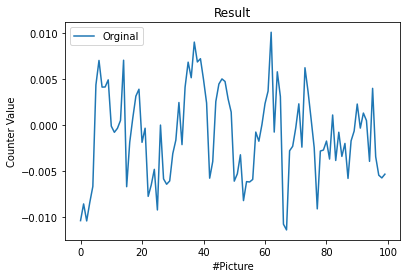

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

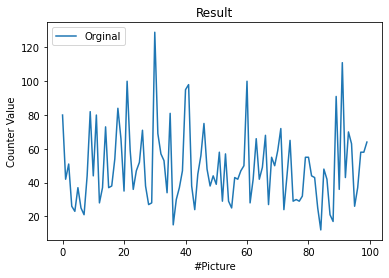

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

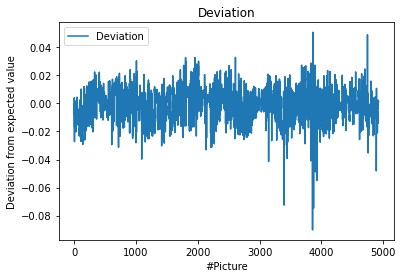

[-0.0007  0.0102 -0.0902  0.0507]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoiqj9zmm\assets


204280

In [15]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 32, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8
converter2.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp0g1bl1fs\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp0g1bl1fs\assets


60096